In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import copy
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99) #here
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.jpg')
    save_image1(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', '/_Cam_Heatmap.png')
    save_image1(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', '/_Cam_On_Image.png')
    save_image1(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', '/_Cam_Grayscale.png')
    save_image1(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image1(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    #pretrained_model = model
    return (original_image,
            prep_img,
            target_class)
    
import torch
import torch.nn as nn


class BaseProp(object):
    """
        Base class for backpropagation.
    """

    def __init__(self, model):
        """Init
        # Arguments:
            model: torchvision.models. A pretrained model.
            handle: list. Handle list that register a hook function.
            relu_outputs: list. Forward output after relu.
        """
        self.model = model
        self.handle = []
        self.relu_outputs = []

    def _register_conv_hook(self):

        """
            Register hook function to save gradient w.r.t input image.
        """

        def _record_gradients(module, grad_in, grad_out):
                self.gradients = grad_in[0]

        for _, module in self.model.named_modules():
            if isinstance(module, nn.modules.conv.Conv2d) and module.in_channels == 3:
                backward_handle = module.register_backward_hook(_record_gradients)
                self.handle.append(backward_handle)

    def _register_relu_hooks(self):

        """
            Register hook function to save forward and backward relu result.
        """

        # Save forward propagation output of the ReLU layer
        def _record_output(module, input_, output):
            self.relu_outputs.append(output)

        def _clip_gradients(module, grad_in, grad_out):
            # keep positive forward propagation output
            relu_output = self.relu_outputs.pop()
            relu_output[relu_output > 0] = 1

            # keep positive backward propagation gradient
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)

            # generate modified guided gradient
            modified_grad_out = positive_grad_out * relu_output

            return (modified_grad_out, )

        for _, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                forward_handle = module.register_forward_hook(_record_output)
                backward_handle = module.register_backward_hook(_clip_gradients)
                self.handle.append(forward_handle)
                self.handle.append(backward_handle)

class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

class Backprop(BaseProp):

    """ Generates vanilla or guided backprop gradients of a target class output w.r.t. an input image.
        # Arguments:
            model: torchvision.models. A pretrained model.
            guided: bool. If True, perform guided backpropagation. Defaults to False.
        # Return:
            Backprop Class.
    """

    def __init__(self, model, guided=False):
        super().__init__(model)
        self.model.eval()
        self.guided = guided
        self.gradients = None
        self._register_conv_hook()

    def calculate_gradients(self,
                            input_,
                            target_class=None,
                            take_max=False,
                            use_gpu=False):

        """ Calculate gradient.
            # Arguments
                input_: torch.Tensor. Preprocessed image with shape (1, C, H, W).
                target_class: int. Index of target class. Default to None and use the prediction result as target class.
                take_max: bool. Take the maximum across colour channels. Defaults to False.
                use_gpu. bool. Use GPU or not. Defaults to False.
            # Return:
                Gradient (torch.Tensor) with shape (C, H, W). If take max is True, with shape (1, H, W).
        """

        if self.guided:
            self._register_relu_hooks()

        # Create a empty tensor to save gradients
        self.gradients = torch.zeros(input_.shape)

        output = self.model(input_)

        self.model.zero_grad()

        if output.shape == torch.Size([1]):
            target = None
        else:
            pred_class = output.argmax().item()

            # Create a Tensor with zero elements, set the element at pred class index to be 1
            target = torch.zeros(output.shape)

            # If target class is None, calculate gradient of predicted class.
            if target_class is None:
                target[0][pred_class] = 1
            else:
                target[0][target_class] = 1

            
        # Calculate gradients w.r.t. input image
        output.backward(gradient=target)

        gradients = self.gradients.detach().cpu()[0]

        if take_max:
            gradients = gradients.max(dim=0, keepdim=True)[0]

        for module in self.handle:
            module.remove()
        gradients = gradients.numpy()
        return gradients

import numpy as np

from torch.autograd import Variable
import torch

from PIL import Image

# from guided_backprop import GuidedBackprop  # To use with guided backprop


def generate_smooth_grad(Backprop, prep_img, target_class, param_n, param_sigma_multiplier):
    """
        Generates smooth gradients of given Backprop type. You can use this with both vanilla
        and guided backprop
    Args:
        Backprop (class): Backprop type
        prep_img (torch Variable): preprocessed image
        target_class (int): target class of imagenet
        param_n (int): Amount of images used to smooth gradient
        param_sigma_multiplier (int): Sigma multiplier when calculating std of noise
    """
    # Generate an empty image/matrix
    smooth_grad = np.zeros(prep_img.size()[1:])

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(prep_img) - torch.min(prep_img)).item()
    
    for x in range(param_n):
        # Generate noise
        noise = Variable(prep_img.data.new(prep_img.size()).normal_(mean, sigma**2))
        # Add noise to the image
        noisy_img = prep_img + noise
        # Calculate gradients
        vanilla_grads = Backprop.calculate_gradients(noisy_img, target_class)
        # Add gradients to smooth_grad
        smooth_grad = smooth_grad + vanilla_grads
    # Average it out
    smooth_grad = smooth_grad / param_n
    return smooth_grad

def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [ ]:
#!/usr/bin/env python
"""flashtorch.utils

This module provides utility functions for image handling and tensor
transformation.

"""
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torchvision.models

def load_image(image_path):
    """Loads image as a PIL RGB image.

        Args:
            - **image_path (str) - **: A path to the image

        Returns:
            An instance of PIL.Image.Image in RGB

    """

    return Image.open(image_path).convert('RGB')


def apply_transforms(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor

def apply_transforms_v0(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor()
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor


def denormalize(tensor):
    """Reverses the normalisation on a tensor.

    Performs a reverse operation on a tensor, so the pixel value range is
    between 0 and 1. Useful for when plotting a tensor into an image.

    Normalisation: (image - mean) / std
    Denormalisation: image * std + mean

    Args:
        tensor (torch.Tensor, dtype=torch.float32): Normalized image tensor

    Shape:
        Input: :math:`(N, C, H, W)`
        Output: :math:`(N, C, H, W)` (same shape as input)

    Return:
        torch.Tensor (torch.float32): Demornalised image tensor with pixel
            values between [0, 1]

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    denormalized = tensor.clone()

    for channel, mean, std in zip(denormalized[0], means, stds):
        channel.mul_(std).add_(mean)

    return denormalized


def standardize_and_clip(tensor, min_value=0.0, max_value=1.0):
    """Standardizes and clips input tensor.

    Standardize the input tensor (mean = 0.0, std = 1.0), ensures std is 0.1
    and clips it to values between min/max (default: 0.0/1.0).

    Args:
        tensor (torch.Tensor):
        min_value (float, optional, default=0.0)
        max_value (float, optional, default=1.0)

    Shape:
        Input: :math:`(C, H, W)`
        Output: Same as the input

    Return:
        torch.Tensor (torch.float32): Normalised tensor with values between
            [min_value, max_value]

    """

    tensor = tensor.detach().cpu()

    mean = tensor.mean()
    std = tensor.std()
    if std == 0:
        std += 1e-7

    standardized = tensor.sub(mean).div(std).mul(0.1)
    clipped = standardized.add(0.5).clamp(min_value, max_value)

    return clipped


def format_for_plotting(tensor):
    """Formats the shape of tensor for plotting.

    Tensors typically have a shape of :math:`(N, C, H, W)` or :math:`(C, H, W)`
    which is not suitable for plotting as images. This function formats an
    input tensor :math:`(H, W, C)` for RGB and :math:`(H, W)` for mono-channel
    data.

    Args:
        tensor (torch.Tensor, torch.float32): Image tensor

    Shape:
        Input: :math:`(N, C, H, W)` or :math:`(C, H, W)`
        Output: :math:`(H, W, C)` or :math:`(H, W)`, respectively

    Return:
        torch.Tensor (torch.float32): Formatted image tensor (detached)

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()


def visualize(input_, gradients, gradients1, save_path=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """

    input_ = format_for_plotting(denormalize(input_))
    gradients = format_for_plotting(standardize_and_clip(gradients))
    gradients1 = format_for_plotting(standardize_and_clip(gradients1))
    subplots = [
        ('', [(input_, None, None)]), \
        ('', [(input_, None, None), (gradients, cmap, alpha)]), \
        ('', [(input_, None, None), (gradients1, cmap, alpha)]), \
    ]


    num_subplots = len(subplots)

    fig = plt.figure(figsize=(16, 3))

    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            ax.imshow(image, cmap=cmap, alpha=alpha)

        ax.set_title(title)
    if save_path is not None:
        plt.savefig(save_path)

    return images


def basic_visualize(input_, gradients1, gradients2, gradients3, gradients4, \
                    gradients5, gradients6, save_path=None, weight=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """
    input_ = format_for_plotting(denormalize(input_))
    gradients1 = format_for_plotting(standardize_and_clip(gradients1))
    gradients2 = format_for_plotting(standardize_and_clip(gradients2))
    gradients3 = format_for_plotting(standardize_and_clip(gradients3))
    gradients4 = format_for_plotting(standardize_and_clip(gradients4))
    gradients5 = format_for_plotting(standardize_and_clip(gradients5))
    gradients6 = format_for_plotting(standardize_and_clip(gradients6))

    subplots = [
        ('Input', [(input_, None, None)]),
        ('Grad-CAM', [(input_, None, None), (gradients1, cmap, alpha)]), \
        ('Grad-CAM++', [(input_, None, None), (gradients2, cmap, alpha)]), \
        ('Smooth Grad-CAM++', [(input_, None, None), (gradients3, cmap, alpha)]), \
        ('Score-CAM', [(input_, None, None), (gradients4, cmap, alpha)]), \
        ('ISS-CAM(1)', [(input_, None, None), (gradients5, cmap, alpha)]), \
        ('ISS-CAM(2)', [(input_, None, None), (gradients6, cmap, alpha)])
    ]

    num_subplots = len(subplots)

    fig = plt.figure(figsize=(16, 3))
    count = 0
    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            print('hello {}'.format(count))
            count += 1         
            ax.imshow(image, cmap=cmap, alpha=alpha)
            
        ax.set_title(title)
    if save_path is not None:
        plt.savefig(save_path)

    return images


def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'layer4'

    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]

        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


def find_densenet_layer(arch, target_layer_name):
    """Find densenet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_transition1'
            target_layer_name = 'features_transition1_norm'
            target_layer_name = 'features_denseblock2_denselayer12'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'classifier'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """

    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) >= 3:
        target_layer = target_layer._modules[hierarchy[2]]

    if len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[3]]

    return target_layer


def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++

              saliency_map2 = torch.unsqueeze(activations[:, i, :, :], 1)
              
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features_29'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_squeezenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision densenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'features_12'
                target_layer_name = 'features_12_expand3x3'
                target_layer_name = 'features_12_expand3x3_activation'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_googlenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'inception5b'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_mobilenet_layer(arch, target_layer_name):
    """Find mobilenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'features'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_shufflenet_layer(arch, target_layer_name):
    """Find mobilenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'conv5'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_layer(arch, target_layer_name):
    """Find target layer to calculate CAM.

        : Args:
            - **arch - **: Self-defined architecture.
            - **target_layer_name - ** (str): Name of target class.

        : Return:
            - **target_layer - **: Found layer. This layer will be hooked to get forward/backward pass information.
    """

    if target_layer_name.split('_') not in arch._modules.keys():
        raise Exception("Invalid target layer name.")
    target_layer = arch._modules[target_layer_name]
    return target_layer
'''
Part of code borrows from https://github.com/1Konny/gradcam_plus_plus-pytorch
'''

import torch

class BaseCAM(object):
    """ Base class for Class activation mapping.
        : Args
            - **model_dict -** : Dict. Has format as dict(type='vgg', arch=torchvision.models.vgg16(pretrained=True),
            layer_name='features',input_size=(224, 224)).
    """

    def __init__(self, model_dict):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        
        self.model_arch = model_dict['arch']
        self.model_arch.eval()
        #if torch.cuda.is_available():
        #  self.model_arch.cuda()
        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            #if torch.cuda.is_available():
            #  self.gradients['value'] = grad_output[0].cuda()
            
            self.gradients['value'] = grad_output[0]
            
            return None

        def forward_hook(module, input, output):
            #if torch.cuda.is_available():
            #  self.activations['value'] = output.cuda()
            self.activations['value'] = output
            
            return None

        if 'vgg' in model_type.lower():
            self.target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            self.target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            self.target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            self.target_layer = find_alexnet_layer(self.model_arch, layer_name)
        elif 'squeezenet' in model_type.lower():
            self.target_layer = find_squeezenet_layer(self.model_arch, layer_name)
        elif 'googlenet' in model_type.lower():
            self.target_layer = find_googlenet_layer(self.model_arch, layer_name)
        elif 'shufflenet' in model_type.lower():
            self.target_layer = find_shufflenet_layer(self.model_arch, layer_name)
        elif 'mobilenet' in model_type.lower():
            self.target_layer = find_mobilenet_layer(self.model_arch, layer_name)
        else:
            self.target_layer = find_layer(self.model_arch, layer_name)

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def forward(self, input, class_idx=None, retain_graph=False):
        return None

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

import torch.nn.functional as F

class GradCAM(BaseCAM):
    """
        GradCAM, inherit from BaseCAM
    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input_, class_idx=None, retain_graph=False):
        """Generates GradCAM result.

        # Arguments
            input_: torch.Tensor. Preprocessed image with shape (1, C, H, W).
            class_idx: int. Index of target class. Defaults to be index of predicted class.

        # Return
            Result of GradCAM (torch.Tensor) with shape (1, H, W).
        """

        b, c, h, w = input_.size()
        logit = self.model_arch(input_)

        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)

        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        
        saliency_map = (weights * activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map

import torch
import torch.nn.functional as F

class SmoothGradCAMpp(GradCAM):
  
  def __init__(self, model_dict):
    super(SmoothGradCAMpp, self).__init__(model_dict)

  def forward(self, input_image, class_idx=None, retain_graph=False):

    b, c, h, w = input_image.size()

    logit = self.model_arch(input_image)
    if class_idx is None:
        score = logit[:, logit.max(1)[-1]].squeeze()
    else:
        score = logit[:, class_idx].squeeze()

    
    if torch.cuda.is_available():
      score = score.cuda()
      logit = logit.cuda()

    self.model_arch.zero_grad()
    score.backward(retain_graph=retain_graph)
    gradients = self.gradients['value']
    activations = self.activations['value']
    b, k, u, v = gradients.size()

    if torch.cuda.is_available():
      activations = activations.cuda()
      gradients = gradients.cuda() 


    mean = 0
    param_n = 35
    param_sigma_multiplier = 2

    grad_2, grad_3 = torch.zeros_like(activations), torch.zeros_like(activations)

    for i in range(param_n):
      
      noise = Variable(input_image.data.new(input_image.size()).normal_(0,param_sigma_multiplier**2))

      noisy_input = input_image + noise
      noisy_input = noisy_input.cuda()
      out = self.model_arch(noisy_input)
      score = out[:, out.max(1)[-1]].squeeze()
      self.model_arch.zero_grad()
      score.backward(retain_graph=retain_graph)
      gradient = self.gradients['value']
      
      grad_2.add_(gradient.pow(2))
      grad_3.add_(gradient.pow(3))

    grad_2.div_(param_n)
    grad_3.div_(param_n)

    # Alpha coefficient for each pixel

    global_sum = activations.view(b, k, u * v).sum(-1, keepdim=True).view(b, k, 1, 1)
    alpha_num = grad_2
    alpha_denom = grad_2.mul(2) + global_sum.mul(grad_3)

    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

    alpha = alpha_num.div(alpha_denom + 1e-7)
    positive_gradients = F.relu(score.exp() * gradients)
    weights = (alpha * positive_gradients).view(b, k, u * v).sum(-1).view(b, k, 1, 1)

    saliency_map = (weights * activations).sum(1, keepdim=True)
    saliency_map = F.relu(saliency_map)
    saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

    return saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
      return self.forward(input, class_idx, retain_graph)


class GradCAMpp(GradCAM):
    """
        GradCAM++, inherit from BaseCAM
    """

    def __init__(self, model_dict):
        super(GradCAMpp, self).__init__(model_dict)

    def forward(self, input_image, class_idx=None, retain_graph=False):

        """Generates GradCAM++ result.
        # Arguments
            input_image: torch.Tensor. Preprocessed image with shape (1, C, H, W).
            class_idx: int. Index of target class. Defaults to be index of predicted class.
        # Return
            Result of GradCAM++ (torch.Tensor) with shape (1, H, W).
        """

        b, c, h, w = input_image.size()

        logit = self.model_arch(input_image)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        
        if torch.cuda.is_available():
          score = score.cuda()
          logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        if torch.cuda.is_available():
          activations = activations.cuda()
          gradients = gradients.cuda()
        
        alpha_num = gradients.pow(2)

        global_sum = activations.view(b, k, u * v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = gradients.pow(2).mul(2) + global_sum.mul(gradients.pow(3))

        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom + 1e-7)
        positive_gradients = F.relu(score.exp() * gradients)
        weights = (alpha * positive_gradients).view(b, k, u * v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights * activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map


class ScoreCAM(BaseCAM):

    """
        ScoreCAM, inherit from BaseCAM
    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input).cuda()
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        if torch.cuda.is_available():
          predicted_class= predicted_class.cuda()
          score = score.cuda()
          logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b, k, u, v = activations.size()
        
        score_saliency_map = torch.zeros((1, 1, h, w))

        if torch.cuda.is_available():
          activations = activations.cuda()
          score_saliency_map = score_saliency_map.cuda()

        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
              
              if saliency_map.max() == saliency_map.min():
                continue
              # normalize to 0-1
              norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              # how much increase if keeping the highlighted region
              # predication on masked input
              output = self.model_arch(input * norm_saliency_map)
              output = F.softmax(output)
              score = output[0][predicted_class]

              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


class ISS_CAM1(BaseCAM):

    """
        ISS-CAM - 1
        Integrating over the upsampled activation map
    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        if torch.cuda.is_available():
          predicted_class= predicted_class.cuda()
          score = score.cuda()
          logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b1, k, u, v = activations.size()

        
        score_saliency_map = torch.zeros((1, 1, h, w))

        if torch.cuda.is_available():
          activations = activations.cuda()
          score_saliency_map = score_saliency_map.cuda()


        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
              
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
 
              if saliency_map.max() == saliency_map.min():
                continue
              
              x = saliency_map               

              score_list = []
              newmap_list = []

              c = 0.01
              new_map = 0

              for i in range(1, 11):
                new_map += x * c * i

                newmap_list.append(new_map)
               
                output = self.model_arch(new_map * input)
                output = F.softmax(output)
                score = output[0][predicted_class]
                score_list.append(score)
              
              score = max(score_list) - min(score_list)
              #score = sum(score_list) / len(score_list)
              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


class ISS_CAM2(BaseCAM):

    """
        ISS-CAM - 2
        Integrating over the normalized input mask        
    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        if torch.cuda.is_available():
          predicted_class= predicted_class.cuda()
          score = score.cuda()
          logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b1, k, u, v = activations.size()

        
        score_saliency_map = torch.zeros((1, 1, h, w))

        if torch.cuda.is_available():
          activations = activations.cuda()
          score_saliency_map = score_saliency_map.cuda()

        

        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
              
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)

              if saliency_map.max() == saliency_map.min():
                continue

              # normalize to 0-1
              norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())              

              
              x = input * norm_saliency_map

              #if i % 50 == 0 and i < 300:
              #  visualize(input.cpu(), x.type(torch.FloatTensor).cpu())         

              score_list = []
              newmap_list = []

              c = 0.1
              new_map = 0
              
              for i in range(1, 11):
                new_map += x * c * i
                
                newmap_list.append(new_map)
                
                output = self.model_arch(new_map)
                output = F.softmax(output)
                score = output[0][predicted_class]
                score_list.append(score)
                
              score = max(score_list) - min(score_list)
              #score = sum(score_list) / len(score_list)
              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)



'''
class ScoreCAM2(BaseCAM):

    """
        ScoreCAM, inherit from BaseCAM

    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        if torch.cuda.is_available():
          predicted_class= predicted_class.cuda()
          score = score.cuda()
          logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b1, k, u, v = activations.size()

        #gradients = self.gradients['value']
        #b2, k, u, v = gradients.size()

        #alpha = gradients.view(b2, k, -1).mean(2)
        #weights = alpha.view(b2, k, 1, 1)
        #print(weights.size())
        
        score_saliency_map = torch.zeros((1, 1, h, w))

        if torch.cuda.is_available():
          activations = activations.cuda()
          score_saliency_map = score_saliency_map.cuda()

        mean = 0
        param_n = 35
        param_sigma_multiplier = 2
        

        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
              #saliency_map *= torch.unsqueeze(weights[:, i, :, :], 1)
              
              #saliency_map = (saliency_map).sum(1, keepdim=True)
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
 
              if saliency_map.max() == saliency_map.min():
                continue

                # normalize to 0-1
              #saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              #x = input * saliency_map

              x = saliency_map               

              if (torch.max(x) - torch.min(x)).item() == 0:
                continue
              else:
                sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
              
              score_list = []
              noisy_list = []
              
              for _ in range(param_n):

                noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
                #noise = Variable(x.data.new(x.size()).uniform_(0,1))
                noisy_img = x + noise

                noisy_list.append(noisy_img)
               
                output = self.model_arch(noisy_img * input)
                output = F.softmax(output)
                score = output[0][predicted_class]
                score_list.append(score)
              
              
              score = sum(score_list) / len(score_list)
              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

class ScoreCAM3(BaseCAM):

    """
        ScoreCAM, inherit from BaseCAM

    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        if torch.cuda.is_available():
          predicted_class= predicted_class.cuda()
          score = score.cuda()
          logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b1, k, u, v = activations.size()

        #gradients = self.gradients['value']
        #b2, k, u, v = gradients.size()

        #alpha = gradients.view(b2, k, -1).mean(2)
        #weights = alpha.view(b2, k, 1, 1)
        #print(weights.size())
        
        score_saliency_map = torch.zeros((1, 1, h, w))

        if torch.cuda.is_available():
          activations = activations.cuda()
          score_saliency_map = score_saliency_map.cuda()

        mean = 0
        param_n = 35
        param_sigma_multiplier = 2
        

        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
              #saliency_map *= torch.unsqueeze(weights[:, i, :, :], 1)
              
              #saliency_map = (saliency_map).sum(1, keepdim=True)
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)

              if saliency_map.max() == saliency_map.min():
                continue

              #if i % 50 == 0 and i < 300:
              #  visualize(input.cpu(), saliency_map.type(torch.FloatTensor).cpu())
              # normalize to 0-1
              norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              # how much increase if keeping the highlighted region
              # predication on masked input
              #output = self.model_arch(input * norm_saliency_map)
              #output = F.softmax(output)
              #score = output[0][predicted_class]


                # normalize to 0-1
              #saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              x = input * norm_saliency_map

              #if i % 50 == 0 and i < 300:
              #  visualize(input.cpu(), x.type(torch.FloatTensor).cpu())         


              if (torch.max(x) - torch.min(x)).item() == 0:
                continue
              else:
                sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
              
              score_list = []
              noisy_list = []
              
              for i in range(param_n):

                noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
                #noise = Variable(x.data.new(x.size()).uniform_(0,1))

                noisy_img = x + noise

                noisy_list.append(noisy_img)
                
                #if i % 10 == 0:
                #  visualize(input.cpu(), noisy_img.type(torch.FloatTensor).cpu())
                
                output = self.model_arch(noisy_img)
                output = F.softmax(output)
                score = output[0][predicted_class]
                score_list.append(score)
                
              score = sum(score_list) / len(score_list)
              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)
'''

'\nclass ScoreCAM2(BaseCAM):\n\n    """\n        ScoreCAM, inherit from BaseCAM\n\n    """\n\n    def __init__(self, model_dict):\n        super().__init__(model_dict)\n\n    def forward(self, input, class_idx=None, retain_graph=False):\n        b, c, h, w = input.size()\n        \n        # predication on raw input\n        logit = self.model_arch(input)\n        \n        if class_idx is None:\n            predicted_class = logit.max(1)[-1]\n            score = logit[:, logit.max(1)[-1]].squeeze()\n        else:\n            predicted_class = torch.LongTensor([class_idx])\n            score = logit[:, class_idx].squeeze()\n        \n        logit = F.softmax(logit)\n\n        if torch.cuda.is_available():\n          predicted_class= predicted_class.cuda()\n          score = score.cuda()\n          logit = logit.cuda()\n\n        self.model_arch.zero_grad()\n        score.backward(retain_graph=retain_graph)\n        activations = self.activations[\'value\']\n        b1, k, u, v = acti

In [ ]:
import pandas as pd
import os
from PIL import Image
import cv2

In [ ]:
#f = os.listdir("/gdrive/My Drive/data")
#len(f)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/test_bbox.csv')
# df
df



,image_name,coordinates
0,ILSVRC2012_val_00030970,"[[81, 48, 412, 406]]"
1,ILSVRC2012_val_00012706,"[[7, 102, 638, 422]]"
2,ILSVRC2012_val_00012977,"[[182, 207, 239, 256]]"
3,ILSVRC2012_val_00012414,"[[35, 2, 366, 256]]"
4,ILSVRC2012_val_00037081,"[[33, 91, 490, 628]]"
...,...,...
1995,ILSVRC2012_val_00017576,"[[16, 2, 497, 476]]"
1996,ILSVRC2012_val_00024137,"[[264, 246, 291, 270]]"
1997,ILSVRC2012_val_00002886,"[[125, 0, 499, 309]]"
1998,ILSVRC2012_val_00003477,"[[1, 3, 499, 340]]"


In [ ]:
model = models.vgg16(pretrained=True)
model = model.cuda()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
'''
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 1000), \
                                    nn.Softmax(dim=1))

model.classifier
'''

'\nn_inputs = model.classifier[6].in_features\n\n# Add on classifier\nmodel.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 1000),                                     nn.Softmax(dim=1))\n\nmodel.classifier\n'

In [ ]:
for index, row in df.iterrows():
  row['image_name'] = '/content/drive/My Drive/test/' + row['image_name'] + '.JPEG'

[81, 48, 412, 406]


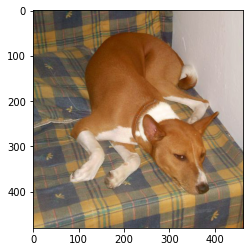

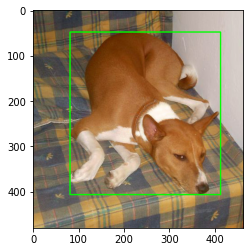

[7, 102, 638, 422]


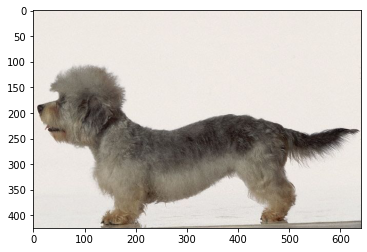

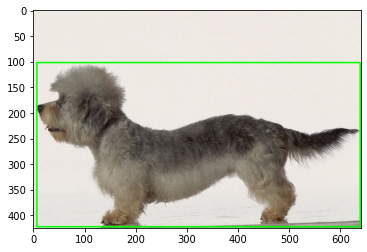

[182, 207, 239, 256]


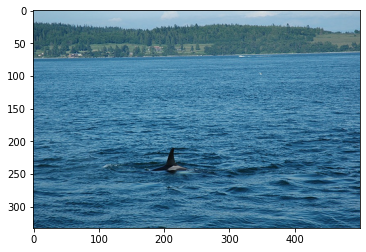

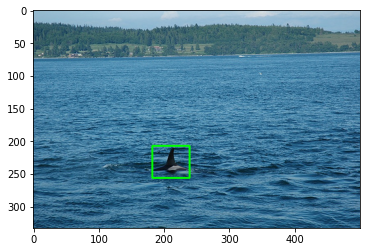

[35, 2, 366, 256]


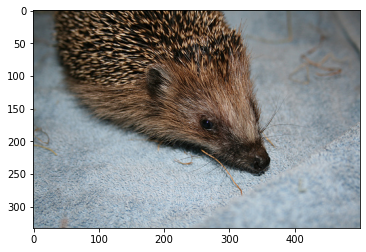

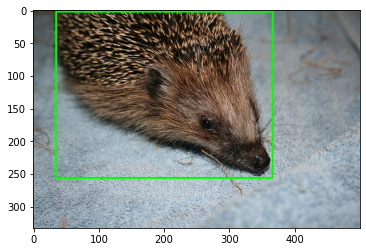

[33, 91, 490, 628]


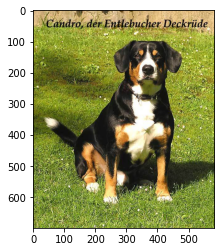

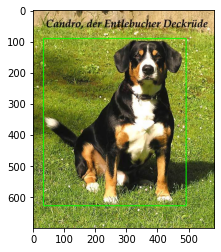

In [ ]:
import re
# num = [int(s) for s in re.findall(r'-?\d+\.?\d*', df['coordinates'][1][1:-1])][0:4]
# print(num)


# arr=np.zeros((224,224))
# arr
# import matplotlib.pyplot as plt
# import cv2
# img = 
# plt.imshow()
# img = load_image('/content/drive/My Drive/test/' + df['image_name'][0] + '.JPEG')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range (5):
  num = [int(s) for s in re.findall(r'-?\d+\.?\d*', df['coordinates'][i][1:-1])][0:4]
  print(num)
  image = mpimg.imread(df['image_name'][i])


 
  plt.imshow(image)
  plt.show()

  # Show with bounding box
  path=df['image_name'][i]
  image2=cv2.imread(path)
  image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
  window_name='Check'
  sp=(num[0],num[1])
  ep=(num[2],num[3])
  color=(0,255,0)
  thickness=2
  image2=cv2.rectangle(image2,sp,ep,color,thickness)
  plt.imshow(image2)
  plt.show()
  
  # # Apply the binary mask 
  # bin_mask = np.zeros((image.shape,3))
  # #bin_mask[num[0]:num[]][num[1]:num[3]] = 1
  # for i in range(num[0],num[1]+1):
  #   for j in range(num[2],num[3]+1):
  #     bin_mask[i][j]=1
  # print(image.shape)
  # image_new=image*bin_mask
  # plt.imshow(image_new.astype('uint8'))
  # plt.show()


In [ ]:
def  calc_energy(mymap,retl,x,y,a,b,intensity):
  my_convert = mymap[0][0].cpu().numpy().astype(np.float32)
  im_new=Image.fromarray(np.uint8(my_convert*255), 'L')
  im_new.save('/content/drive/My Drive/intermediate.jpg')

  #Load it back again

  matrix=cv2.imread('/content/drive/My Drive/intermediate.jpg',cv2.IMREAD_GRAYSCALE)

  b_mask=np.where(matrix>intensity,1,0)

  num=0

  for i in range(len(matrix[0])):
    for j in range(len(matrix)):
      if i>=x and i<=x+a and j>=y and j<=y+b:
        if b_mask[i][j]==1:
          num+=1

  denom=0
  for i in range(len(matrix[0])):
    for j in range(len(matrix)):
      if b_mask[i][j]==1:
        denom+=1
  print(num/denom)
  retl.append(num/denom)
   

In [ ]:
# def performance_metrics(input_, smap, ):
#   Lc = smap
#   I = input_
#   Ec = Lc * I

#   # Average Drop % = torch.sum(torch.div(torch.max(0, Yc - Oc),Yc))*100

#   # % Increase in Confidence = torch.sum((Yc < Oc).to(torch.int32)/N)*100




In [ ]:
# df1 = df[110:120]
# #print(df1)
# #x5 = [['/gdrive/My Drive/ILSVRC2012_val_00000653.JPEG']]
# #for i in range(len(df1)):
# c = 0
# for index, row in df1.iterrows():
#   c += 1
#   if c == 10:
#     break
#   X = model.eval()

#   x_model_dict = dict(type='vgg', arch=X, layer_name='features', input_size=(224, 224))

#   x_scorecam = ScoreCAM(x_model_dict)

#   input_image = load_image(row['image_name'])
#   input_ = apply_transforms(input_image)
  
#   if torch.cuda.is_available():
#     input_cuda = input_.cuda()
  
#   x = X(input_cuda)
#   predicted_class = x.max(1)[-1]


#   #pred1 = X(input_cuda)[0][0]
#   #predscore1 = X(input_cuda)[0][218]
#   #predscore2 = X(input_cuda)[0][219]
#   #p1 = X(input_cuda).max(1)

#   #print(X(input_cuda)[0])
#   ##print(p1)
#   #print(pred1, predscore1, predscore2)
#   #print(X(input_cuda)[0])

#   scorecam_map = x_scorecam(input_cuda)
#   print(predicted_class)

#   _, index = torch.max(x, 1)
  
#   percentage = torch.nn.functional.softmax(x, dim=1)[0] * 100                   #Yc
  
#   print(index[0], percentage[index[0]].item())

#   smoothpp = SmoothGradCAMpp(x_model_dict)
#   smpp_map = smoothpp(input_cuda)

#   x_scorecam1 = ISS_CAM2(x_model_dict) 
#   scorecam_map1 = x_scorecam1(input_cuda)

#   x_scorecam2 = ISS_CAM2(x_model_dict)
#   scorecam_map2 = x_scorecam2(input_cuda)


#   gradcam = GradCAM(x_model_dict)
#   gradcam_map = gradcam(input_cuda)

  
#   gradcampp = GradCAMpp(x_model_dict)
#   gradcampp_map = gradcampp(input_cuda)

#   basic_visualize(input_cuda.cpu(), \
#                   gradcam_map.type(torch.FloatTensor).cpu(), \
#                   gradcampp_map.type(torch.FloatTensor).cpu(), \
#                   smpp_map.type(torch.FloatTensor).cpu(), \
#                   scorecam_map.type(torch.FloatTensor).cpu(), \
#                   scorecam_map1.type(torch.FloatTensor).cpu(), \
#                   scorecam_map2.type(torch.FloatTensor).cpu())

In [ ]:
avg_drop = 0      # Global variable used for Average drop percentage 
inc_conf = 0      # Global variable used for % Increase in confidence

def printMap(smap):
  img_map = smap.type(torch.FloatTensor).cpu().view(224,224,-1).expand(-1, -1, 3)
  plt.imshow(img_map)

def performance_metrics(eval_model, input_, smap, input_predicted_percent):
  metrics = dict()

  Lc = smap.cpu()
  I = input_.cpu()

  Ec = torch.mul(Lc,I)
  
  if torch.cuda.is_available():
    Ec_cuda = Ec.cuda()
  
  x = X(Ec_cuda)
  predicted_class = x.max(1)[-1]
  print(predicted_class)

  _, index = torch.max(x, 1)
  
  Yc = input_predicted_percent[index[0]].item()

  percentage = torch.nn.functional.softmax(x, dim=1)[0]
  # print("index: ",index)
  # print(Oc.shape)
  # print(Oc)                   
  Oc = percentage[index[0]].item()*100
  print("Yc = ", Yc)
  print("Oc = ", Oc)

  diff = Yc - Oc
  # print(diff.type())
  print('Diff = ',diff)

  avg_drop = max(0.0, diff)/Yc

  inc_conf = int(Yc<Oc)

  print("Avg drop = ",avg_drop)

  metrics['avg_drop'] = avg_drop
  metrics['inc_conf'] = inc_conf
  metrics['diff'] = diff

  return metrics


10
[[95, 63, 411, 283]]
[95, 63, 411, 283]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:899: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:932: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.5644907505847332
[0.5644907505847332]
Predicted Class:  tensor([265], device='cuda:0')
tensor(265, device='cuda:0') 48.070556640625
0.7433724790644666
[0.7433724790644666]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:974: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1019: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.57024693836579
[0.57024693836579]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1064: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.5687053829828285
[0.5687053829828285]
0.4560517038777908
[0.4560517038777908]
0.7159660004594532
[0.7159660004594532]
hello 0
hello 1
hello 2
hello 3
hello 4
hello 5
hello 6
hello 7
hello 8
hello 9
hello 10
hello 11
hello 12
ScoreCam_Map2
tensor([265], device='cuda:0')
Yc =  48.070556640625
Oc =  59.36487913131714
Diff =  -11.294322490692139
Avg drop =  0.0
ScoreCam_Map1
tensor([265], device='cuda:0')
Yc =  48.070556640625
Oc =  56.72749876976013
Diff =  -8.656942129135132
Avg drop =  0.0
ScoreCam_Map
tensor([265], device='cuda:0')
Yc =  48.070556640625
Oc =  44.639185070991516
Diff =  3.431371569633484
Avg drop =  0.07138198118416608
11
[[141, 112, 319, 282]]
[141, 112, 319, 282]
0.08012315623657454
[0.08012315623657454]
Predicted Class:  tensor([174], device='cuda:0')
tensor(174, device='cuda:0') 55.76693344116211
0.12650217335719766
[0.12650217335719766]
0.09083910700538876
[0.09083910700538876]
0.0888645552560647
[0.0888645552560647]
0.22330011723329427
[0.22330011723329427]
0.12

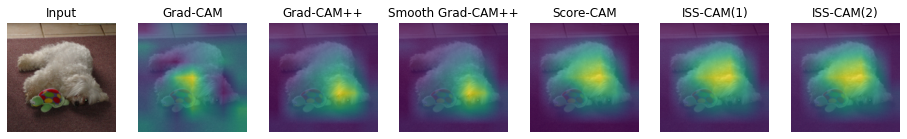

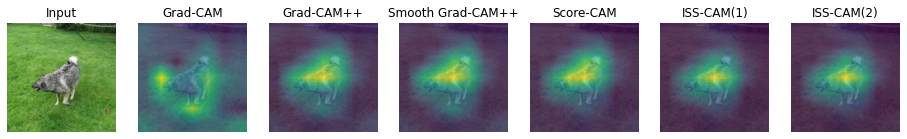

In [ ]:
avg_drop_scam = 0.0      # Global variables used for Average drop percentage 
avg_drop_iscam1 = 0.0
avg_drop_iscam2 = 0.0

inc_conf_scam = 0.0      # Global variables used for % Increase in confidence
inc_conf_iscam1 = 0.0
inc_conf_iscam2 = 0.0

win_scam = 0.0           # Global variables used for Win %
win_iscam1 = 0.0
win_iscam2 = 0.0

N = 0         # Total Count of Images Tested

df1 = df[10:12]

c = 0
for index, row in df1.iterrows():
  print(index)
  c += 1
  #if c == 11:
  #  break

  N+=1
  X = model.eval()

  x_model_dict = dict(type='vgg', arch=X, layer_name='features', input_size=(224, 224))

  x_scorecam = ScoreCAM(x_model_dict)
   
  #bounding box coordinates
  print(row['coordinates'])
  nums = [int(s) for s in re.findall(r'-?\d+\.?\d*', df1['coordinates'][index][1:-1])][0:4]
  #nums=row['coordinates'][0]
  print(nums)
  
  input_image = load_image(row['image_name'])
  input_ = apply_transforms(input_image)
  
  if torch.cuda.is_available():
    input_cuda = input_.cuda()
  
  x = X(input_cuda)
  predicted_class = x.max(1)[-1]

  scorecam_map = x_scorecam(input_cuda)

 # Energy based point game code goes here 

  energy_score=[]
  intensity=50
  calc_energy(scorecam_map,energy_score,int(nums[0]),int(nums[1]),int(nums[2]),int(nums[3]),intensity)
  print(energy_score)
####################################################################################################
  print("Predicted Class: ",predicted_class)

  _, index = torch.max(x, 1)
  
  percentage = torch.nn.functional.softmax(x, dim=1)[0] * 100 
  
  print(index[0], percentage[index[0]].item())
  ###############################################
  smoothpp = SmoothGradCAMpp(x_model_dict)
  smpp_map = smoothpp(input_cuda)
  energy_score_smpp=[]
  intensity=50
  calc_energy(smpp_map,energy_score_smpp,int(nums[0]),int(nums[1]),int(nums[2]),int(nums[3]),intensity)
  print(energy_score_smpp)
  ###############################################

  x_scorecam1 = ISS_CAM1(x_model_dict) 
  scorecam_map1 = x_scorecam1(input_cuda)
  energy_score_smap1=[]
  intensity=50
  calc_energy(scorecam_map1,energy_score_smap1,int(nums[0]),int(nums[1]),int(nums[2]),int(nums[3]),intensity)
  print(energy_score_smap1)
  #################################################

  x_scorecam2 = ISS_CAM2(x_model_dict)
  scorecam_map2 = x_scorecam2(input_cuda)
  energy_score_smap2=[]
  intensity=50
  calc_energy(scorecam_map2,energy_score_smap2,int(nums[0]),int(nums[1]),int(nums[2]),int(nums[3]),intensity)
  print(energy_score_smap2)

  #################################################
  gradcam = GradCAM(x_model_dict)
  gradcam_map = gradcam(input_cuda)
  energy_score_gradcam=[]
  intensity=50
  calc_energy(gradcam_map,energy_score_gradcam,int(nums[0]),int(nums[1]),int(nums[2]),int(nums[3]),intensity)
  print(energy_score_gradcam)
  ##################################################
  gradcampp = GradCAMpp(x_model_dict)
  gradcampp_map = gradcampp(input_cuda)
  energy_score_gradcampp=[]
  intensity=50
  calc_energy(gradcampp_map,energy_score_gradcampp,int(nums[0]),int(nums[1]),int(nums[2]),int(nums[3]),intensity)
  print(energy_score_gradcampp)
  ##################################################

  basic_visualize(input_cuda.cpu(), \
                  gradcam_map.type(torch.FloatTensor).cpu(), \
                  gradcampp_map.type(torch.FloatTensor).cpu(), \
                  smpp_map.type(torch.FloatTensor).cpu(), \
                  scorecam_map.type(torch.FloatTensor).cpu(), \
                  scorecam_map1.type(torch.FloatTensor).cpu(), \
                  scorecam_map2.type(torch.FloatTensor).cpu())

  print('ScoreCam_Map2')
  metric_results = performance_metrics(X, input_, scorecam_map2, percentage)
  avg_drop_iscam2 += metric_results['avg_drop']
  inc_conf_iscam2 += metric_results['inc_conf']
  diff_iscam2 = metric_results['diff']

  print('ScoreCam_Map1')
  metric_results = performance_metrics(X, input_, scorecam_map1, percentage)
  avg_drop_iscam1 += metric_results['avg_drop']
  inc_conf_iscam1 += metric_results['inc_conf']
  diff_iscam1 = metric_results['diff']

  print('ScoreCam_Map')
  metric_results = performance_metrics(X, input_, scorecam_map, percentage)
  avg_drop_scam += metric_results['avg_drop']
  inc_conf_scam += metric_results['inc_conf']
  diff_scam = metric_results['diff']

  if diff_iscam2 < diff_scam:
    win_iscam2+=1
  
  if diff_iscam1 < diff_scam:
    win_iscam1+=1
  

print("\nAverage Drop % Integrated Score-CAM2 = ", avg_drop_iscam2*100)
print("Average Drop % Integrated Score-CAM1 = ", avg_drop_iscam1*100)
print("Average Drop % Score-CAM = ", avg_drop_scam*100)

print("\n% Increase in Confidence Integrated Score-CAM2 = ", (inc_conf_iscam2/N)*100)
print("% Increase in Confidence Integrated Score-CAM1 = ", (inc_conf_iscam1/N)*100)
print("% Increase in Confidence Score-CAM = ", (inc_conf_scam/N)*100)

print("\nWin % Integrated Score-CAM2 wrt Score-CAM = ", (win_iscam2/N)*100)
print("Win % Integrated Score-CAM1 wrt Score-CAM = ", (win_iscam1/N)*100)